### Assignment 3 Version 2 

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [40]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim
# from torchsummary import summary
from torchvision.models import resnet50, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob
from tqdm import tqdm

# Data Classes

In [41]:
class Data():
    def __init__(self, root, paths, labels, transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
     
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i] if self.labels else None
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = (self.get_no_transform(i))[0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

In [42]:
class TestData():
    def __init__(self, root, paths,transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img in index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        img = self.transform(img)
        return img
    
    '''
    predict output for each test image
    '''
    def predict(self, dataloader, model):
        all_preds = torch.Tensor([]).to(device) # specify dtype
        model.eval()
        for batch_index,images in enumerate(dataloader):
            test_images = images.to(device)
            outputs = model(test_images)
            _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
            all_preds = torch.cat((all_preds,preds))
        preds = all_preds.tolist()
        preds = [int(x) for x in all_preds]
        return preds
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        return img
    
    '''
    print sample data from test
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    write predictions into answer.csv for submission to kaggle
    '''
    def write_predictions(self, predictions, csv_file, output_file):
        file = pd.read_csv(self.root+"/"+csv_file)
        file['Predicted'] = predictions
        file.to_csv(output_file, sep=',', index=False)


# The Model Class

In [43]:
class A3ResNetV2():
    def __init__(self, device):
        self.device = device
        
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2).to(self.device)
        
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
        )
        
        self.model.fc = self.fc
        self.model.to(self.device)
    
    '''
    freeze all feature layers in the network, does not freeze the fully
    connected layer at the end
    '''
    def freeze_features(self):
        for name,param in self.model.named_parameters():
            if "fc" in name:
                continue
            else:
                param.requires_grad=False
    
    '''
    unfreeze all features, gradient calculates for all conv layers with this called
    '''
    def unfreeze_features(self):
        for param in self.model.parameters():
            param.requires_grad = True
    
    '''
    helper function to check which layers have gradient calculating.
    Yes means its being updated, and No is not updated
    '''
    def print_grad_settings(self):
        for i in self.model.parameters():
            if i.requires_grad==True:
                print("YES")
            else:
                print("NO")
    
    '''
    helper function to print model and summary
    '''
    def print_model(self):
        summary(self.model, (3,224,224))
    
    '''
    function to train the model on a given dataloader,optimizer, and loss function.
    runs for specified number of epochs.
    '''
    def train_model(self, epochs, train_dataloader, optimizer, loss_function, scheduler):
        self.model.train()
        for i in tqdm(range(epochs)):
            
            epoch_loss = 0
            num_examples = 0
            correct_examples = 0
            
            for batch_index,(images,labels) in enumerate(train_dataloader):
                # reset optimizer for the current batch
                optimizer.zero_grad() 
                # load images and labels
                images = images.to(device)
                labels = labels.to(device)
                # calculate output and loss from output
                outputs = self.model(images)
                loss = loss_function(outputs,labels)
                # loss.backward() calculates all gradients for all params, optimizer.step() updates params using our optimizer
                loss.backward()
                optimizer.step()
                # calculate information for this epoch
                epoch_loss += loss.item()*len(labels)
                num_examples += len(labels)
                # calculate predictions and accuracy
                _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
                # print("Preds",preds)
                correct_examples += (preds==labels).sum().item()
            
            # AFTER epoch we calculate accuracy and step scheduler
            train_accuracy = (correct_examples/num_examples)*100
            print(f'Epoch {i}: Training Accuracy: {train_accuracy:.4f}%, Training Loss: {epoch_loss:.4f}')
            # scheduler.step()

    '''
    validates model on validation set
    '''
    def validate_model(self, validation_dataloader):
        self.model.eval() 
        num_examples = 0
        correct_examples = 0
        
        for batch_index,(images,labels) in tqdm(enumerate(validation_dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            num_examples += len(labels)
            _ , preds = torch.max(outputs,1)
            # print(preds)
            correct_examples += (preds==labels).sum().item()
            
        validation_accuracy = (correct_examples / num_examples)*100
        print(f'Validation Accuracy: {validation_accuracy:.20f}%')


# Data Preperation

In [44]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9,1.3)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ColorJitter(contrast=0.1),
    transforms.ColorJitter(saturation=0.1),
    
    transforms.Resize(size=(224,224)),     
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [45]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),     
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Old Resize:
# transforms.Resize(256),
# torchvision.transforms.CenterCrop(224),


##### Load the training and test paths from spreadsheets and setup the data loaders

In [46]:
df_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/train.csv"))
train_paths = df_csv["id"].to_list()
train_labels = df_csv["label"].to_list()

test_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/test.csv"))
test_paths = test_csv["id"].values

In [47]:
train_dataset = Data("./Assignment 3 Dataset", train_paths, train_labels, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TestData("./Assignment 3 Dataset", test_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Sampels of training and test data

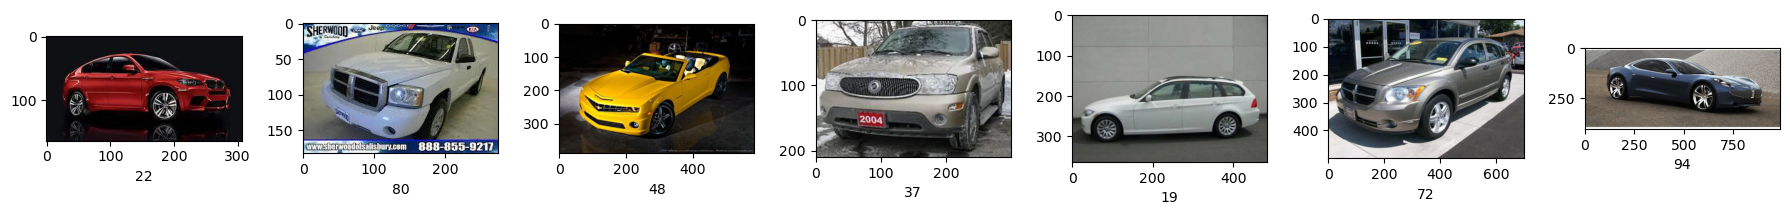

In [48]:
train_dataset.print_samples()

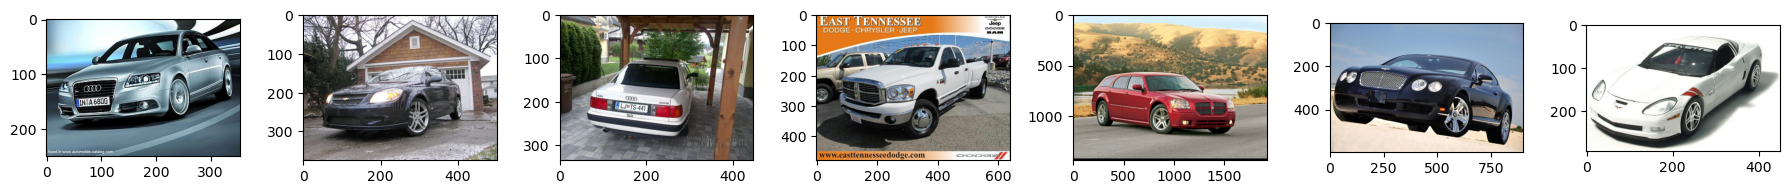

In [49]:
test_dataset.print_samples()

# Instantiating the Model and Making Predictions

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [51]:
resnet = A3ResNetV2(device)

In [52]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

### Training

To begin training, we will first freeze the feature portion of the network and only train the fully connected layer (classifier) for several epochs.

We will then unfreeze the network and train the entire thing afterwards for many more epochs, and intermittantly make predictions intermitently

In [53]:
resnet.freeze_features()
for i in range(4):
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler)
    
    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer_fully_connected"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [01:41<11:48, 101.17s/it]

Epoch 0: Training Accuracy: 1.5961%, Training Loss: 19037.1194


 25%|██▌       | 2/8 [03:14<09:38, 96.45s/it] 

Epoch 1: Training Accuracy: 2.7328%, Training Loss: 18565.7736


 38%|███▊      | 3/8 [04:52<08:06, 97.27s/it]

Epoch 2: Training Accuracy: 4.5707%, Training Loss: 16703.6536


 50%|█████     | 4/8 [06:32<06:33, 98.25s/it]

Epoch 3: Training Accuracy: 8.8996%, Training Loss: 15062.9956


 62%|██████▎   | 5/8 [08:13<04:57, 99.21s/it]

Epoch 4: Training Accuracy: 12.2370%, Training Loss: 13509.5633


 75%|███████▌  | 6/8 [09:52<03:18, 99.33s/it]

Epoch 5: Training Accuracy: 18.5248%, Training Loss: 12487.5271


 88%|████████▊ | 7/8 [11:28<01:38, 98.25s/it]

Epoch 6: Training Accuracy: 21.7170%, Training Loss: 11567.4312


100%|██████████| 8/8 [13:00<00:00, 97.59s/it]

Epoch 7: Training Accuracy: 26.6505%, Training Loss: 10712.3035



 12%|█▎        | 1/8 [01:26<10:08, 86.86s/it]

Epoch 0: Training Accuracy: 29.9637%, Training Loss: 10080.7420


 25%|██▌       | 2/8 [02:54<08:42, 87.07s/it]

Epoch 1: Training Accuracy: 33.2527%, Training Loss: 9297.5881


 38%|███▊      | 3/8 [04:30<07:35, 91.16s/it]

Epoch 2: Training Accuracy: 37.0738%, Training Loss: 8824.3493


 50%|█████     | 4/8 [06:08<06:16, 94.15s/it]

Epoch 3: Training Accuracy: 42.0798%, Training Loss: 8134.1988


 62%|██████▎   | 5/8 [07:41<04:41, 93.71s/it]

Epoch 4: Training Accuracy: 43.4341%, Training Loss: 7781.4771


 75%|███████▌  | 6/8 [09:11<03:04, 92.36s/it]

Epoch 5: Training Accuracy: 47.4244%, Training Loss: 7327.4273


 88%|████████▊ | 7/8 [10:41<01:31, 91.58s/it]

Epoch 6: Training Accuracy: 50.5683%, Training Loss: 6836.5870


100%|██████████| 8/8 [12:12<00:00, 91.55s/it]

Epoch 7: Training Accuracy: 53.0109%, Training Loss: 6397.2718



 12%|█▎        | 1/8 [01:31<10:38, 91.16s/it]

Epoch 0: Training Accuracy: 55.3809%, Training Loss: 5937.7356


 25%|██▌       | 2/8 [03:02<09:07, 91.17s/it]

Epoch 1: Training Accuracy: 57.3881%, Training Loss: 5836.9323


 38%|███▊      | 3/8 [04:33<07:36, 91.38s/it]

Epoch 2: Training Accuracy: 59.7823%, Training Loss: 5544.9188


 50%|█████     | 4/8 [06:05<06:05, 91.40s/it]

Epoch 3: Training Accuracy: 61.0883%, Training Loss: 5171.5375


 62%|██████▎   | 5/8 [07:33<04:30, 90.29s/it]

Epoch 4: Training Accuracy: 64.2080%, Training Loss: 4820.1830


 75%|███████▌  | 6/8 [09:05<03:01, 90.92s/it]

Epoch 5: Training Accuracy: 66.6264%, Training Loss: 4368.5091


 88%|████████▊ | 7/8 [10:34<01:30, 90.24s/it]

Epoch 6: Training Accuracy: 66.6022%, Training Loss: 4373.3480


100%|██████████| 8/8 [12:05<00:00, 90.71s/it]

Epoch 7: Training Accuracy: 69.2624%, Training Loss: 4118.0679



 12%|█▎        | 1/8 [01:31<10:40, 91.52s/it]

Epoch 0: Training Accuracy: 70.8343%, Training Loss: 3860.9668


 25%|██▌       | 2/8 [03:02<09:06, 91.12s/it]

Epoch 1: Training Accuracy: 72.7690%, Training Loss: 3605.6232


 38%|███▊      | 3/8 [04:33<07:36, 91.24s/it]

Epoch 2: Training Accuracy: 73.3253%, Training Loss: 3595.7234


 50%|█████     | 4/8 [06:04<06:03, 90.94s/it]

Epoch 3: Training Accuracy: 74.7521%, Training Loss: 3360.7945


 62%|██████▎   | 5/8 [07:35<04:32, 90.97s/it]

Epoch 4: Training Accuracy: 76.1548%, Training Loss: 3133.8037


 75%|███████▌  | 6/8 [09:03<02:59, 89.91s/it]

Epoch 5: Training Accuracy: 75.5985%, Training Loss: 3196.6714


 88%|████████▊ | 7/8 [10:34<01:30, 90.36s/it]

Epoch 6: Training Accuracy: 78.1620%, Training Loss: 2906.3319


100%|██████████| 8/8 [12:05<00:00, 90.71s/it]

Epoch 7: Training Accuracy: 78.7908%, Training Loss: 2808.7176


In [54]:
resnet.unfreeze_features()
for i in range(7):
    
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler) # train the model for 9 epochs

    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [02:01<14:07, 121.09s/it]

Epoch 0: Training Accuracy: 37.9927%, Training Loss: 9825.9139


 25%|██▌       | 2/8 [04:09<12:32, 125.48s/it]

Epoch 1: Training Accuracy: 61.8138%, Training Loss: 5434.9707


 38%|███▊      | 3/8 [06:15<10:27, 125.54s/it]

Epoch 2: Training Accuracy: 74.8247%, Training Loss: 3312.6532


 50%|█████     | 4/8 [08:16<08:14, 123.69s/it]

Epoch 3: Training Accuracy: 82.0798%, Training Loss: 2257.3207


 62%|██████▎   | 5/8 [10:17<06:08, 122.89s/it]

Epoch 4: Training Accuracy: 85.9250%, Training Loss: 1770.4955


 75%|███████▌  | 6/8 [12:08<03:57, 118.91s/it]

Epoch 5: Training Accuracy: 87.6663%, Training Loss: 1516.4522


 88%|████████▊ | 7/8 [14:01<01:56, 116.75s/it]

Epoch 6: Training Accuracy: 90.3748%, Training Loss: 1160.8245


100%|██████████| 8/8 [15:52<00:00, 119.06s/it]

Epoch 7: Training Accuracy: 92.2612%, Training Loss: 932.9249



 12%|█▎        | 1/8 [01:59<13:58, 119.84s/it]

Epoch 0: Training Accuracy: 92.1161%, Training Loss: 1026.6620


 25%|██▌       | 2/8 [04:00<12:01, 120.28s/it]

Epoch 1: Training Accuracy: 94.7521%, Training Loss: 650.9870


 38%|███▊      | 3/8 [06:00<10:00, 120.06s/it]

Epoch 2: Training Accuracy: 94.1959%, Training Loss: 740.4084


 50%|█████     | 4/8 [07:57<07:55, 118.96s/it]

Epoch 3: Training Accuracy: 95.2116%, Training Loss: 596.1901


 62%|██████▎   | 5/8 [09:56<05:57, 119.04s/it]

Epoch 4: Training Accuracy: 95.5744%, Training Loss: 547.2257


 75%|███████▌  | 6/8 [11:57<03:59, 119.58s/it]

Epoch 5: Training Accuracy: 95.3083%, Training Loss: 558.9321


 88%|████████▊ | 7/8 [13:56<01:59, 119.58s/it]

Epoch 6: Training Accuracy: 96.6385%, Training Loss: 426.3379


100%|██████████| 8/8 [15:55<00:00, 119.42s/it]

Epoch 7: Training Accuracy: 96.0580%, Training Loss: 514.0329



 12%|█▎        | 1/8 [02:00<14:06, 120.89s/it]

Epoch 0: Training Accuracy: 98.0653%, Training Loss: 286.6430


 25%|██▌       | 2/8 [03:58<11:54, 119.11s/it]

Epoch 1: Training Accuracy: 96.9528%, Training Loss: 389.9892


 38%|███▊      | 3/8 [05:55<09:51, 118.21s/it]

Epoch 2: Training Accuracy: 97.3398%, Training Loss: 336.3283


 50%|█████     | 4/8 [07:58<07:59, 119.87s/it]

Epoch 3: Training Accuracy: 97.3881%, Training Loss: 331.4131


 62%|██████▎   | 5/8 [09:58<06:00, 120.05s/it]

Epoch 4: Training Accuracy: 97.3398%, Training Loss: 350.0720


 75%|███████▌  | 6/8 [11:55<03:57, 118.94s/it]

Epoch 5: Training Accuracy: 97.8718%, Training Loss: 265.5956


 88%|████████▊ | 7/8 [13:54<01:58, 118.98s/it]

Epoch 6: Training Accuracy: 98.1378%, Training Loss: 257.6011


100%|██████████| 8/8 [15:57<00:00, 119.64s/it]

Epoch 7: Training Accuracy: 98.0653%, Training Loss: 245.7620



 12%|█▎        | 1/8 [02:00<14:05, 120.85s/it]

Epoch 0: Training Accuracy: 98.3797%, Training Loss: 233.4456


 25%|██▌       | 2/8 [04:01<12:03, 120.61s/it]

Epoch 1: Training Accuracy: 98.4522%, Training Loss: 167.2882


 38%|███▊      | 3/8 [06:01<10:01, 120.36s/it]

Epoch 2: Training Accuracy: 98.0895%, Training Loss: 236.0642


 50%|█████     | 4/8 [07:58<07:56, 119.11s/it]

Epoch 3: Training Accuracy: 98.3071%, Training Loss: 218.1453


 62%|██████▎   | 5/8 [09:57<05:56, 118.88s/it]

Epoch 4: Training Accuracy: 98.5490%, Training Loss: 198.4848


 75%|███████▌  | 6/8 [11:51<03:54, 117.26s/it]

Epoch 5: Training Accuracy: 98.9117%, Training Loss: 124.9453


 88%|████████▊ | 7/8 [13:43<01:55, 115.65s/it]

Epoch 6: Training Accuracy: 98.6457%, Training Loss: 183.8173


100%|██████████| 8/8 [15:36<00:00, 117.08s/it]

Epoch 7: Training Accuracy: 98.3555%, Training Loss: 195.1965



 12%|█▎        | 1/8 [02:01<14:13, 121.87s/it]

Epoch 0: Training Accuracy: 98.8150%, Training Loss: 150.9129


 25%|██▌       | 2/8 [04:05<12:15, 122.64s/it]

Epoch 1: Training Accuracy: 98.9601%, Training Loss: 145.2528


 38%|███▊      | 3/8 [06:01<09:58, 119.62s/it]

Epoch 2: Training Accuracy: 98.9359%, Training Loss: 134.4826


 50%|█████     | 4/8 [07:54<07:48, 117.12s/it]

Epoch 3: Training Accuracy: 98.9359%, Training Loss: 121.9071


 62%|██████▎   | 5/8 [09:46<05:46, 115.38s/it]

Epoch 4: Training Accuracy: 98.9359%, Training Loss: 160.2736


 75%|███████▌  | 6/8 [11:39<03:48, 114.44s/it]

Epoch 5: Training Accuracy: 98.9843%, Training Loss: 130.9671


 88%|████████▊ | 7/8 [13:31<01:53, 113.83s/it]

Epoch 6: Training Accuracy: 98.2588%, Training Loss: 222.8935


100%|██████████| 8/8 [15:24<00:00, 115.54s/it]

Epoch 7: Training Accuracy: 98.7666%, Training Loss: 156.2740



 12%|█▎        | 1/8 [01:52<13:10, 113.00s/it]

Epoch 0: Training Accuracy: 98.5006%, Training Loss: 193.4810


 25%|██▌       | 2/8 [03:45<11:15, 112.64s/it]

Epoch 1: Training Accuracy: 98.5732%, Training Loss: 176.7347


 38%|███▊      | 3/8 [05:37<09:21, 112.33s/it]

Epoch 2: Training Accuracy: 98.8150%, Training Loss: 160.7833


 50%|█████     | 4/8 [07:29<07:29, 112.44s/it]

Epoch 3: Training Accuracy: 99.1778%, Training Loss: 115.8042


 62%|██████▎   | 5/8 [09:22<05:36, 112.33s/it]

Epoch 4: Training Accuracy: 99.5889%, Training Loss: 54.9476


 75%|███████▌  | 6/8 [11:14<03:44, 112.28s/it]

Epoch 5: Training Accuracy: 99.3229%, Training Loss: 87.9895


 88%|████████▊ | 7/8 [13:06<01:52, 112.30s/it]

Epoch 6: Training Accuracy: 99.1778%, Training Loss: 104.9729


100%|██████████| 8/8 [14:59<00:00, 112.38s/it]

Epoch 7: Training Accuracy: 99.4921%, Training Loss: 66.6547



 12%|█▎        | 1/8 [01:51<13:03, 111.91s/it]

Epoch 0: Training Accuracy: 99.2019%, Training Loss: 79.0686


 25%|██▌       | 2/8 [03:44<11:12, 112.11s/it]

Epoch 1: Training Accuracy: 99.2745%, Training Loss: 94.0657


 38%|███▊      | 3/8 [05:36<09:22, 112.43s/it]

Epoch 2: Training Accuracy: 99.5647%, Training Loss: 54.6600


 50%|█████     | 4/8 [07:29<07:29, 112.47s/it]

Epoch 3: Training Accuracy: 99.6614%, Training Loss: 45.9547


 62%|██████▎   | 5/8 [09:21<05:37, 112.42s/it]

Epoch 4: Training Accuracy: 99.1294%, Training Loss: 109.4972


 75%|███████▌  | 6/8 [11:14<03:44, 112.34s/it]

Epoch 5: Training Accuracy: 99.2019%, Training Loss: 120.1237


 88%|████████▊ | 7/8 [13:06<01:52, 112.26s/it]

Epoch 6: Training Accuracy: 99.2261%, Training Loss: 90.5790


100%|██████████| 8/8 [14:57<00:00, 112.24s/it]

Epoch 7: Training Accuracy: 99.1294%, Training Loss: 121.7782


### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160